In [2]:
import os
os.chdir("../../")

In [3]:
import copy
import glob
import math
import yaml

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from cids.util import misc_funcs as misc
from cids.data import SCVIC_CIDS_CLASSES, SCVIC_CIDS_CLASSES_INV
from cids.util import metrics

In [4]:
def load_configs(paths, base=True):
    configs = {}
    for path in paths:
        with open(path, "r") as f:
            print(f"Loading {path}")
            config = yaml.safe_load(f)
        key = "model_type" if base else "id"
        configs[config["experiment"][key]] = config
    return configs


baseline_config_paths = glob.glob(os.path.join(misc.root(), "config/01_supervision/baseline-binary/*.yaml"))
baseline_config_paths = [p for p in baseline_config_paths if "OPTC" not in p]
unsupervised_config_paths = glob.glob(os.path.join(misc.root(), "config/02_anomaly_detection/baseline/*.yaml"))
unsupervised_config_paths = [p for p in unsupervised_config_paths if "OPTC" not in p]

baseline_configs = load_configs(baseline_config_paths, base=True)
unsupervised_configs = load_configs(unsupervised_config_paths, base=False)

Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/baseline-binary/RF.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/baseline-binary/MLP.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/baseline-binary/CIDS.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/01_supervision/baseline-binary/CMLP.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/02_anomaly_detection/baseline/MLPAE-1.yaml
Loading /opt/gildemeister/gildemeister-implementation/config/02_anomaly_detection/baseline/MLPAE-2.yaml


In [5]:
def load_confusion(key, config, base_path, binary=False, source="test"):
    confusion_matrix = np.zeros((len(config["experiment"]["seed"]), len(SCVIC_CIDS_CLASSES), 2 if binary else len(SCVIC_CIDS_CLASSES)))
    experiment_config = config["experiment"]
    for j in range(len(config["experiment"]["seed"])):
        confusion_matrix_seed = pd.read_csv(os.path.join(base_path, f"{experiment_config["id"]}-{j}/{source}_confusion.csv"), index_col=0, header=0)
        confusion_matrix[j] = confusion_matrix_seed.to_numpy()
    
    return confusion_matrix

In [7]:
source = "test" # One of train | val | test
base_confusion_matrices = {}
unsupervised_confusion_matrices = {}

for k, config in baseline_configs.items():
    experiment_config = config["experiment"]
    base_confusion_matrices[k] = load_confusion(k, config, base_path = os.path.join(misc.root(), f"results/01_supervision/baseline-binary/{experiment_config["model_type"]}/{experiment_config["id"]}/"), binary=True, source=source)

for k, config in unsupervised_configs.items():
    experiment_config = config["experiment"]
    unsupervised_confusion_matrices[k] = load_confusion(k, config, base_path = os.path.join(misc.root(), f"results/02_anomaly-detection/baseline/{config["dataset"]["ds_name"]}/{experiment_config["model_type"]}/{experiment_config["id"]}/"), binary=True, source=source)


In [8]:
print(base_confusion_matrices.keys())

dict_keys(['RF', 'MLP', 'CIDS', 'CMLP'])


In [9]:
# Number of classes
n_classes = len(SCVIC_CIDS_CLASSES)

# For each model, create a 10x2x2 matrix: [seed, [benign/malicious], [pred_benign/pred_malicious]]
base_binary_confusions = {}

for model, confusions in base_confusion_matrices.items():
    n_seeds = confusions.shape[0]
    binary_conf = np.zeros((n_seeds, 2, 2))
    for i in range(n_seeds):
        # True Benign: class 0
        tp_benign = confusions[i, 0, 0]
        fp_benign = confusions[i, 0, 1]
        # True Malicious: sum over all other classes
        tp_malicious = confusions[i, 1:, 1].sum()
        fp_malicious = confusions[i, 1:, 0].sum()
        # Fill matrix
        binary_conf[i, 0, 0] = tp_malicious
        binary_conf[i, 0, 1] = fp_malicious
        binary_conf[i, 1, 0] = fp_benign
        binary_conf[i, 1, 1] = tp_benign
    base_binary_confusions[model] = binary_conf

    # For unsupervised models, create a 10x2x2 matrix: [seed, [benign/malicious], [pred_benign/pred_malicious]]
    unsupervised_binary_confusions = {}

    for model, confusions in unsupervised_confusion_matrices.items():
        n_seeds = confusions.shape[0]
        binary_conf = np.zeros((n_seeds, 2, 2))
        for i in range(n_seeds):
            tn = confusions[i, 0, 0]
            fp = confusions[i, 0, 1]
            tp = confusions[i, 1:, 1].sum()
            fn = confusions[i, 1:, 0].sum()
            binary_conf[i, 0, 0] = tp
            binary_conf[i, 0, 1] = fn
            binary_conf[i, 1, 0] = fp
            binary_conf[i, 1, 1] = tn
        unsupervised_binary_confusions[model] = binary_conf

In [10]:
for k in base_binary_confusions.keys():
    mccs = [metrics.mcc_from_confusion_matrix(base_binary_confusions[k][i]) for i in range(base_binary_confusions[k].shape[0])]
    f1s = [metrics.f1_from_confusion_matrix(base_binary_confusions[k][i]) for i in range(base_binary_confusions[k].shape[0])]
    precisions = [metrics.precision_from_confusion_matrix(base_binary_confusions[k][i]) for i in range(base_binary_confusions[k].shape[0])]
    recalls = [metrics.recall_from_confusion_matrix(base_binary_confusions[k][i]) for i in range(base_binary_confusions[k].shape[0])]

    tps = [base_binary_confusions[k][i, 0, 0] for i in range(base_binary_confusions[k].shape[0])]
    tns = [base_binary_confusions[k][i, 1, 1] for i in range(base_binary_confusions[k].shape[0])]
    fps = [base_binary_confusions[k][i, 1, 0] for i in range(base_binary_confusions[k].shape[0])]
    fns = [base_binary_confusions[k][i, 0, 1] for i in range(base_binary_confusions[k].shape[0])]

    print(f"Model: {k}\n"
          f"\tMean MCC: {np.mean(mccs):.3f} +/- {np.std(mccs):.3f}\n"
          f"\tMean F1: {np.mean(f1s):.3f} +/- {np.std(f1s):.3f}\n"
          f"\tMean Precision: {np.mean(precisions):.3f} +/- {np.std(precisions):.3f}\n"
          f"\tMean Recall: {np.mean(recalls):.3f} +/- {np.std(recalls):.3f}\n"
          f"\tMean TP: {np.mean(tps):.1f}, TN: {np.mean(tns):.1f}, FP: {np.mean(fps):.1f}, FN: {np.mean(fns):.1f}")

for k in unsupervised_confusion_matrices.keys():
    mccs = [metrics.mcc_from_confusion_matrix(unsupervised_binary_confusions[k][i]) for i in range(unsupervised_binary_confusions[k].shape[0])]
    f1s = [metrics.f1_from_confusion_matrix(unsupervised_binary_confusions[k][i]) for i in range(unsupervised_binary_confusions[k].shape[0])]
    precisions = [metrics.precision_from_confusion_matrix(unsupervised_binary_confusions[k][i]) for i in range(unsupervised_binary_confusions[k].shape[0])]
    recalls = [metrics.recall_from_confusion_matrix(unsupervised_binary_confusions[k][i]) for i in range(unsupervised_binary_confusions[k].shape[0])]

    tps = [unsupervised_binary_confusions[k][i, 0, 0] for i in range(unsupervised_binary_confusions[k].shape[0])]
    tns = [unsupervised_binary_confusions[k][i, 1, 1] for i in range(unsupervised_binary_confusions[k].shape[0])]
    fps = [unsupervised_binary_confusions[k][i, 1, 0] for i in range(unsupervised_binary_confusions[k].shape[0])]
    fns = [unsupervised_binary_confusions[k][i, 0, 1] for i in range(unsupervised_binary_confusions[k].shape[0])]

    print(f"Model: {k}\n"
          f"\tMean MCC: {np.mean(mccs):.3f} +/- {np.std(mccs):.3f}\n"
          f"\tMean F1: {np.mean(f1s):.3f} +/- {np.std(f1s):.3f}\n"
          f"\tMean Precision: {np.mean(precisions):.3f} +/- {np.std(precisions):.3f}\n"
          f"\tMean Recall: {np.mean(recalls):.3f} +/- {np.std(recalls):.3f}\n"
          f"\tMean TP: {np.mean(tps):.1f}, TN: {np.mean(tns):.1f}, FP: {np.mean(fps):.1f}, FN: {np.mean(fns):.1f}")



Model: RF
	Mean MCC: 0.999 +/- 0.000
	Mean F1: 1.000 +/- 0.000
	Mean Precision: 1.000 +/- 0.000
	Mean Recall: 0.999 +/- 0.000
	Mean TP: 92025.0, TN: 92104.0, FP: 6.0, FN: 84.0
Model: MLP
	Mean MCC: 0.998 +/- 0.000
	Mean F1: 0.999 +/- 0.000
	Mean Precision: 0.999 +/- 0.000
	Mean Recall: 0.999 +/- 0.000
	Mean TP: 92006.2, TN: 92038.1, FP: 71.9, FN: 102.8
Model: CIDS
	Mean MCC: 0.999 +/- 0.000
	Mean F1: 1.000 +/- 0.000
	Mean Precision: 1.000 +/- 0.000
	Mean Recall: 1.000 +/- 0.000
	Mean TP: 92088.9, TN: 92071.3, FP: 38.7, FN: 20.1
Model: CMLP
	Mean MCC: 0.999 +/- 0.000
	Mean F1: 1.000 +/- 0.000
	Mean Precision: 0.999 +/- 0.000
	Mean Recall: 1.000 +/- 0.000
	Mean TP: 92095.4, TN: 92060.7, FP: 49.3, FN: 13.6
Model: MLPAE-1
	Mean MCC: 0.729 +/- 0.082
	Mean F1: 0.865 +/- 0.043
	Mean Precision: 0.842 +/- 0.012
	Mean Recall: 0.892 +/- 0.079
	Mean TP: 82126.5, TN: 76805.1, FP: 15304.9, FN: 9982.5
Model: MLPAE-2
	Mean MCC: 0.775 +/- 0.062
	Mean F1: 0.889 +/- 0.031
	Mean Precision: 0.851 +/- 0.009

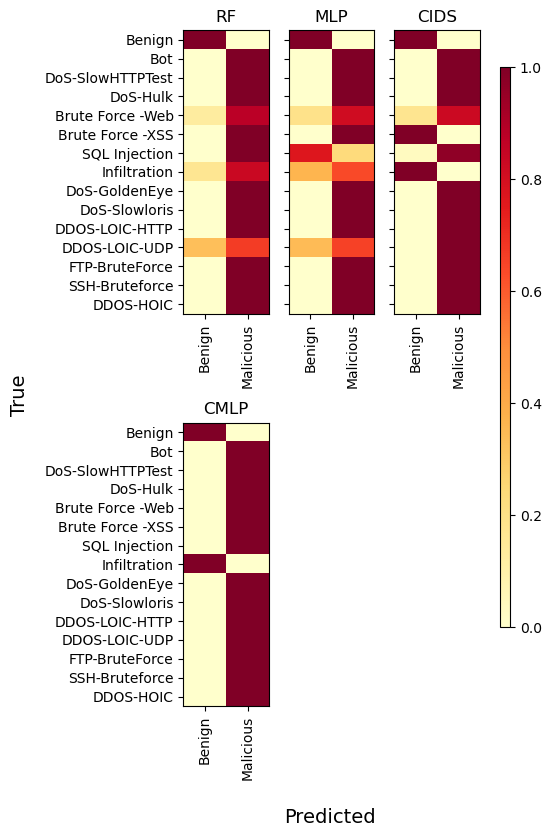

In [11]:
# Plot all average probability confusion matrices for each baseline model as heatmaps in a grid
confusion_matrices = {}
for model in base_confusion_matrices.keys():
    avg_conf_matrix = np.mean(base_confusion_matrices[model], axis=0)
    row_sums = avg_conf_matrix.sum(axis=1, keepdims=True)
    prob_matrix = np.divide(avg_conf_matrix, row_sums, where=row_sums != 0)
    confusion_matrices[model] = prob_matrix

labels = [SCVIC_CIDS_CLASSES_INV[i] for i in range(n_classes)]
rows = math.ceil(len(confusion_matrices) / 3)
fig, axes = plt.subplots(rows, 3, figsize=(5, rows * 4))
axes = axes.flatten()

# Find global vmin and vmax for consistent color scaling
all_matrices = np.array(list(confusion_matrices.values()))
vmin = all_matrices.min()
vmax = all_matrices.max()

im_list = []
for i, ax in enumerate(axes):
    if i >= len(confusion_matrices):
        ax.axis('off')
        continue
    key = list(confusion_matrices.keys())[i]
    im = ax.imshow(confusion_matrices[key], aspect='auto', cmap='YlOrRd', vmin=vmin, vmax=vmax)
    im_list.append(im)
    ax.set_title(f'{key}')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Benign", "Malicious"], rotation=90)
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    # Only set xlabel for the first plot
    ax.set_xlabel('')
    # Remove y-label for second and third axes
    ax.set_ylabel('')
    if i in [1, 2]:
        ax.set_yticklabels([])

plt.tight_layout(rect=[0, 0, 0.93, 1])  # Leave space for colorbar

fig.supxlabel('Predicted', fontsize=14, y=-0.04, x=0.6)  # Adjust x as needed
fig.supylabel('True', fontsize=14, x=-0.04, y=0.5)  # Adjust y as needed
# Place colorbar in a new axes to the right of all subplots
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(axes[-1])
cax = fig.add_axes([0.94, 0.21, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im_list[0], cax=cax, orientation='vertical')

plt.show()

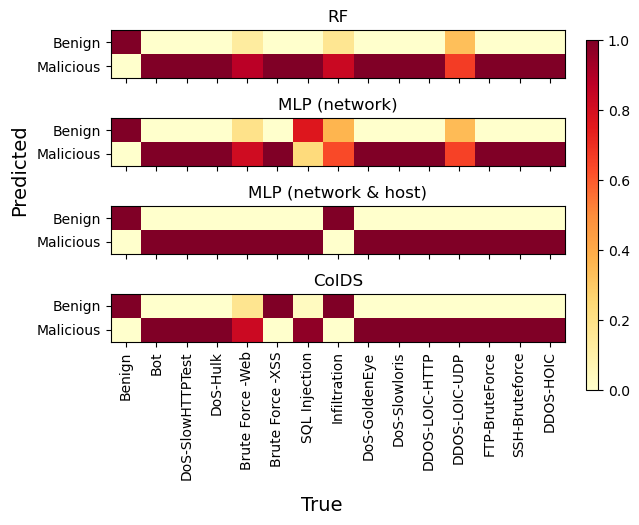

In [15]:
# Plot all average probability confusion matrices for each baseline model as heatmaps in a grid
confusion_matrices = {}
for model in base_confusion_matrices.keys():
    avg_conf_matrix = np.mean(base_confusion_matrices[model], axis=0)
    row_sums = avg_conf_matrix.sum(axis=1, keepdims=True)
    prob_matrix = np.divide(avg_conf_matrix, row_sums, where=row_sums != 0)
    confusion_matrices[model] = prob_matrix

labels = [SCVIC_CIDS_CLASSES_INV[i] for i in range(n_classes)]
rows = len(confusion_matrices)  # One row per model
fig, axes = plt.subplots(rows, 1, figsize=(6,5))  # One column

# If only one model, axes is not a list
if rows == 1:
    axes = [axes]

# Find global vmin and vmax for consistent color scaling
all_matrices = np.array(list(confusion_matrices.values()))
vmin = all_matrices.min()
vmax = all_matrices.max()

im_list = []
models=["RF", "MLP (network)", "MLP (network & host)", "CoIDS"]
keys = ["RF", "MLP", "CMLP", "CIDS"]
for i, ax in enumerate(axes):
    key = keys[i]
    im = ax.imshow(confusion_matrices[key].T, aspect='auto', cmap='YlOrRd', vmin=vmin, vmax=vmax)
    im_list.append(im)
    ax.set_title(f'{models[i]}')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Benign", "Malicious"])

    ax.set_xlabel('')
    # Hide x tick labels for all but last subplot
    if i < len(axes) - 1:
        ax.set_xticklabels([])

plt.tight_layout(rect=[0, 0, 0.93, 1])

# Centered labels for the whole figure
fig.supxlabel('True', fontsize=14, y=-0.04)
fig.supylabel('Predicted', fontsize=14, x=-0.02, y=0.65)

# Place colorbar to the right
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes[-1])
cax = fig.add_axes([0.94, 0.21, 0.02, 0.7])
fig.colorbar(im_list[0], cax=cax, orientation='vertical')

fig.savefig(os.path.join(misc.root(), "plots/confusion_matrix_basefull.pdf"), bbox_inches='tight')
plt.show()

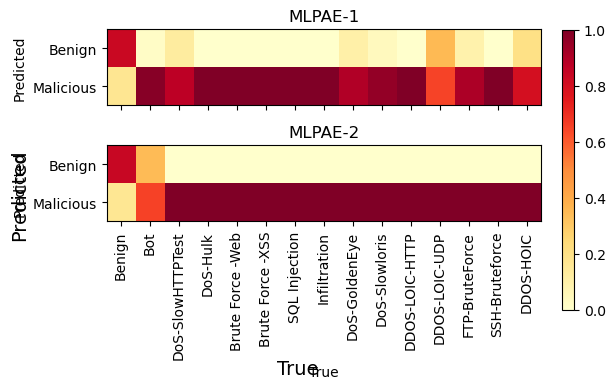

In [17]:
# Plot all average probability confusion matrices for each unsupervised model as heatmaps in a grid
unsup_confusion_matrices = {}
for model in unsupervised_confusion_matrices.keys():
    avg_conf_matrix = np.mean(unsupervised_confusion_matrices[model], axis=0)
    row_sums = avg_conf_matrix.sum(axis=1, keepdims=True)
    prob_matrix = np.divide(avg_conf_matrix, row_sums, where=row_sums != 0)
    unsup_confusion_matrices[model] = prob_matrix

labels = [SCVIC_CIDS_CLASSES_INV[i] for i in range(n_classes)]
rows = len(unsup_confusion_matrices)  # One row per model
fig, axes = plt.subplots(rows, 1, figsize=(6, 4))  # One column

# If only one model, axes is not a list
if rows == 1:
    axes = [axes]

# Find global vmin and vmax for consistent color scaling
all_matrices = np.array(list(unsup_confusion_matrices.values()))
vmin = all_matrices.min()
vmax = all_matrices.max()

im_list = []
for i, ax in enumerate(axes):
    key = list(unsup_confusion_matrices.keys())[i]
    im = ax.imshow(unsup_confusion_matrices[key].T, aspect='auto', cmap='YlOrRd', vmin=vmin, vmax=vmax)
    im_list.append(im)
    ax.set_title(f'{key}')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Benign", "Malicious"])
    # Only label x-axis for the last subplot
    if i == len(axes) - 1:
        ax.set_xlabel('True')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    ax.set_ylabel('Predicted')

plt.tight_layout(rect=[0, 0, 0.93, 1])

# Centered labels for the whole figure
fig.supxlabel('True', fontsize=14, y=0.04)
fig.supylabel('Predicted', fontsize=14, x=0.02)

# Place colorbar to the right
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes[-1])
cax = fig.add_axes([0.94, 0.21, 0.02, 0.7])
fig.colorbar(im_list[0], cax=cax, orientation='vertical')

fig.savefig(os.path.join(misc.root(), "plots/confusion_matrix_unsupervised.pdf"), bbox_inches='tight')
plt.show()

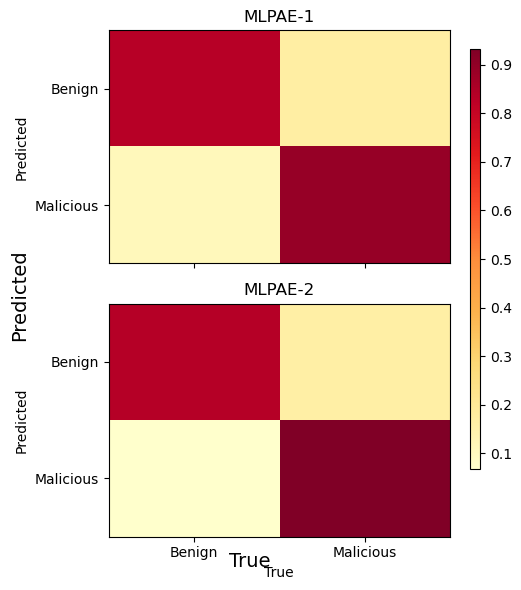

In [10]:
# Plot binary confusion matrices for each unsupervised model as heatmaps (malicious classes combined)
unsup_binary_conf_matrices = {}
for model, confusions in unsupervised_confusion_matrices.items():
    n_seeds = confusions.shape[0]
    binary_conf = np.zeros((n_seeds, 2, 2))
    for i in range(n_seeds):
        # True Benign: class 0
        tn = confusions[i, 0, 0]
        fp = confusions[i, 0, 1]
        # True Malicious: all other classes
        tp = confusions[i, 1:, 1].sum()
        fn = confusions[i, 1:, 0].sum()
        binary_conf[i, 0, 0] = tn
        binary_conf[i, 0, 1] = fp
        binary_conf[i, 1, 0] = fn
        binary_conf[i, 1, 1] = tp
    unsup_binary_conf_matrices[model] = binary_conf

# Plot average probability binary confusion matrices for each unsupervised model
binary_labels = ["Benign", "Malicious"]
rows = len(unsup_binary_conf_matrices)
fig, axes = plt.subplots(rows, 1, figsize=(5, 3 * rows))
if rows == 1:
    axes = [axes]

# Find global vmin and vmax for consistent color scaling
all_matrices = np.array([np.mean(m, axis=0) / np.sum(np.mean(m, axis=0), axis=1, keepdims=True) for m in unsup_binary_conf_matrices.values()])
vmin = all_matrices.min()
vmax = all_matrices.max()

im_list = []
for i, ax in enumerate(axes):
    key = list(unsup_binary_conf_matrices.keys())[i]
    avg_conf_matrix = np.mean(unsup_binary_conf_matrices[key], axis=0)
    row_sums = avg_conf_matrix.sum(axis=1, keepdims=True)
    prob_matrix = np.divide(avg_conf_matrix, row_sums, where=row_sums != 0)
    im = ax.imshow(prob_matrix, aspect='auto', cmap='YlOrRd', vmin=vmin, vmax=vmax)
    im_list.append(im)
    ax.set_title(f'{key}')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(binary_labels)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(binary_labels)
    # Only label x-axis for the last subplot
    if i == len(axes) - 1:
        ax.set_xlabel('True')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    ax.set_ylabel('Predicted')

plt.tight_layout(rect=[0, 0, 0.93, 1])
fig.supxlabel('True', fontsize=14, y=0.04)
fig.supylabel('Predicted', fontsize=14, x=0.02)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes[-1])
cax = fig.add_axes([0.94, 0.21, 0.02, 0.7])
fig.colorbar(im_list[0], cax=cax, orientation='vertical')

fig.savefig(os.path.join(misc.root(), "plots/confusion_matrix_unsupervised_binary.pdf"), bbox_inches='tight')
plt.show()